# Music machine learning - Introduction

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [first definition](#definition) on the concept of machine learning
2. An introduction to a simple problem of [linear regression](#regression)
3. An explanation on [model capacity and overfitting](#capacity)
4. An introduction to the [audio datasets](#audio) that we will use

<a id="definition"></a>
## Defining machine learning

In all natural process, there exists complex relations between sets $\mathcal{X} \mapsto \mathcal{Y}$. This can relate some objects with their names, or a cause to a consequence. In most cases, _we do not know the precise relations_ between these sets, all we have is _observations_ such as pairs $(x,y)$, composed of input data $x \in \mathcal{X}$, which have a corresponding expected output $y \in \mathcal{Y}$. The overarching goal of machine learning is to approximate such _unknown processes_ as a function $\mathcal{F}_{\theta}$, which _transforms_ input data $x$ into output data $y$.

<img src="images/01_machine_learning_basic.png" align="center"/>

Hence, machine learning aims to understand and model the relationship between some (usually complex and high-dimensional) inputs $\mathbf{x}\in\mathcal{X}\subset\mathbb{R}^{\mathcal{X}}$ and outputs $\mathbf{y}\in\mathcal{Y}\subset\mathbb{R}^{\mathcal{Y}}$, given by a set of data examples $\mathcal{D}=\left\{(x_1,y_1),\cdots,(x_N,y_N)\right\}$. This is achieved by defining a parametric model $f_{\mathbf{\theta}}\in\mathcal{F}$ inside a family of functions $\mathcal{F}$, which depends on parameters $\mathbf{\theta} \in \mathbf{\Theta}$ and that could approximate the underlying relationship. The _learning_ aspect refers to the adjustment of the parameters $\mathbf{\theta}$ in order to obtain the best approximation of the given task
$$
\begin{equation}
f_{\mathbf{\theta}}(\mathbf{x}) = \hat{\mathbf{y}}\approx \mathbf{y}.
\end{equation}
$$

To observe this idea in simple setups, we are going to use the `numpy` library and `matplotlib` for plotting. We also set some fixed random generator, to ensure reproducibility

In [5]:
# Base imports
import numpy as np

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import torch

In [3]:
from helper_plot import prep_plots, finalize_plots, hdr_plot_style

In [6]:
rng = np.random.RandomState(1)

<a id="regression"></a>
## Simple learning problem

Imagine that a certain process somewhere follows the form of a quadratic relationship

$$
 y = a x^{2} + bx + c 
$$

In this case, all the **unknown parameters** are that of a polynomial model, therefore we have $\theta = \{a, b, c\}$. However, this is clearly an ideal (clean) case, whereas in natural observations, there might be some noise in our observations
$$
 y = a x^{2} + bx + c +\epsilon \quad \mbox{with} \quad \epsilon \in [-0.1, 0.1]
$$

An example of such noisy observations for different parameters is given below

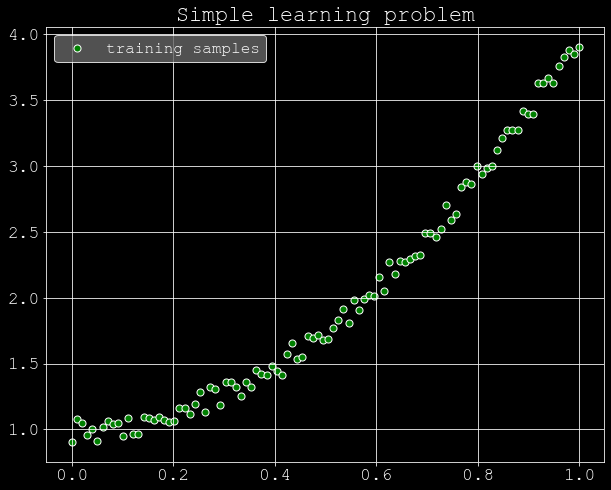

In [7]:
noise_level = 0.1
a, b, c = 3, 0, 1
# Generating 
x = np.linspace(0, 1, 100)
poly = np.poly1d([a, b, c])
epsilon = np.random.uniform(-noise_level,noise_level,x.shape)
y = poly(x) + epsilon
ax1, = prep_plots(["Simple learning problem"], fig_size=(10,8), fig_num=1)
ax1.scatter(x, y, color='green', s=50, marker='o', edgecolor='w', label="training samples")
finalize_plots([ax1], fig_title="")
#plt.xlim([-1, 2])

Now our main problem is that this function can follow different types of parameters

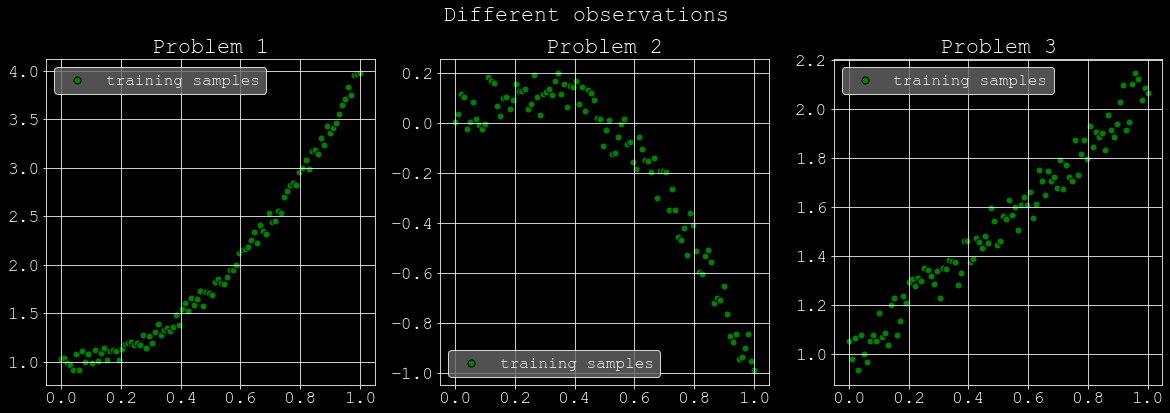

In [8]:
params = [[3, 0, 1], [-2, 1, 0], [0.1, 1, 1]]
ax = prep_plots(["Problem 1", "Problem 2", "Problem 3"], fig_size=(20,6), fig_num=1)
# Generating 
x = np.linspace(0, 1, 100)
for p in range(len(params)):
    poly = np.poly1d(params[p])
    epsilon = np.random.uniform(-noise_level,noise_level,x.shape)
    y = poly(x) + epsilon
    ax[p].scatter(x, y, color='green', s=50, marker='o', edgecolor='k', label="training samples")
finalize_plots(ax, fig_title="Different observations")

In real-life settings, this function can also have different levels of noise, as exemplified in the following code.

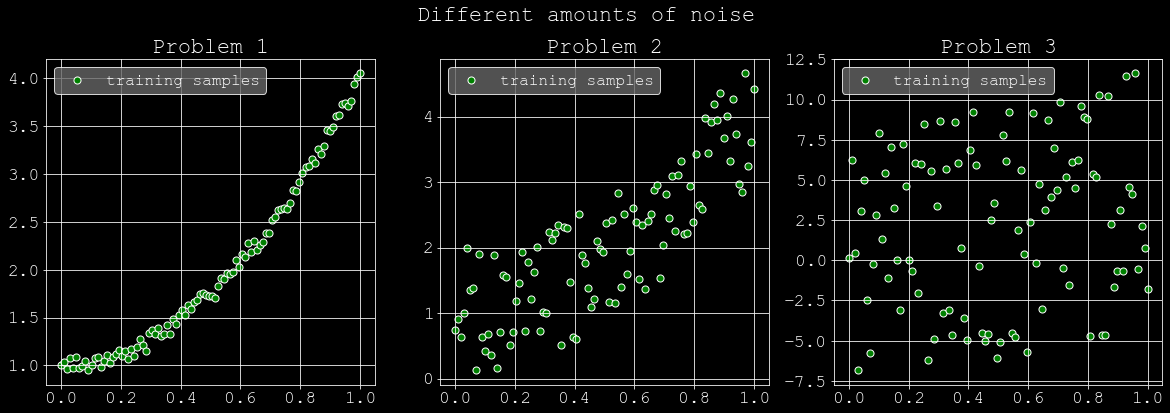

In [9]:
params = [3, 0, 1]
noise_levels = [0.1, 1.0, 8.0]
ax = prep_plots(["Problem 1", "Problem 2", "Problem 3"], fig_size=(20,6), fig_num=1)
# Generating 
x = np.linspace(0, 1, 100)
for p in range(len(noise_levels)):
    poly = np.poly1d(params)
    epsilon = np.random.uniform(-noise_levels[p],noise_levels[p],x.shape)
    y = poly(x) + epsilon
    ax[p].scatter(x, y, color='green', s=50, marker='o', edgecolor='w', label="training samples")
finalize_plots(ax, fig_title="Different amounts of noise")

To summarize, we will have some observations of a function, and we would like to optimize a function that gets as close as possible to the real function that generated this data. Here, we plot the real function and also _subsample_ our number of observations (having only a few points to find the corresponding function)

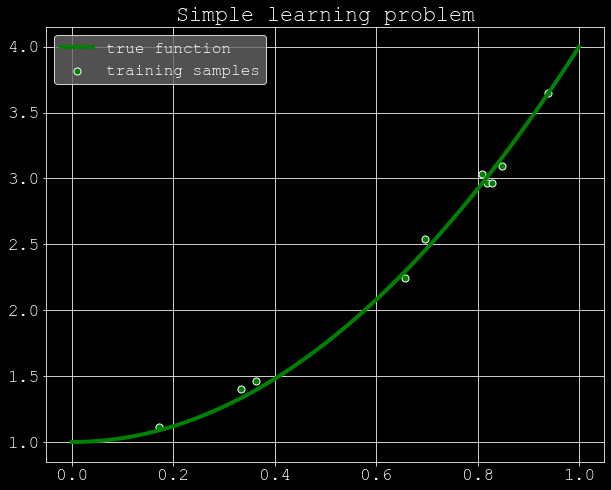

In [10]:
# Generating the data and subsampling
x_all = np.linspace(0, 1, 100); x_plot = np.linspace(0, 1, 100)
rng.shuffle(x_all); x = np.sort(x_all[:10])
poly = np.poly1d([3,0,1])
# Adding some external
epsilon = np.random.uniform(-0.1,0.1,x.shape)
y = poly(x)+ epsilon
# We keep the standard deviation for later
nnstd = np.std(epsilon); lw = 2
ax1, = prep_plots(["Simple learning problem"], fig_size=(10,8), fig_num=1)
ax1.plot(x_plot, poly(x_plot), color='green', linewidth=4, label='true function')
ax1.scatter(x, y, color='green', s=50, marker='o', edgecolor='w', label="training samples")
finalize_plots([ax1], fig_title="")

To get a first grip on what machine learning does, we will rely on the `scikit-learn` library. This contains already coded models and learning procedure, that will allow us to _learn_ the parameters of this unknown function.

Here we already know that we want to use a `PolynomialFeatures` model to perfom `LinearRegression` and that this polynomial should be of degree 2.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Our data to fit
X = x[:, np.newaxis]
# Degree of our polynomial
degree = 2;
# Create our polynomial model for regression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit the parameters of this model
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

Now that we have trained the model, we can perform _predictions_ from it, meaning that we can infer the output of the function at values that we did not observe originally.

Model error : 0.05276234841694862


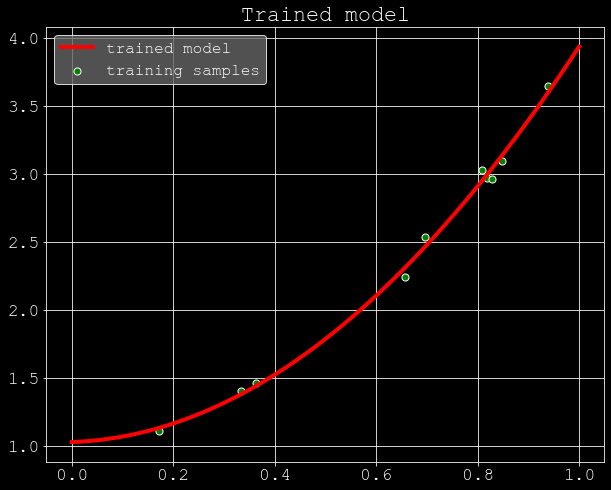

In [12]:
# Inference points (not observed)
X_plot = x_plot[:, np.newaxis]
# Predict the values
y_plot = model.predict(X_plot)
# Compute the error of our model at observed points
Y_model_err = np.sqrt(np.mean(np.square(y-model.predict(X))))
# Plot the result
ax1, = prep_plots(["Trained model"], fig_size=(10,8), fig_num=1)
ax1.plot(x_plot, y_plot, color='red', linewidth=4, label='trained model')
ax1.scatter(x, y, color='green', s=50, marker='o', edgecolor='w', label="training samples")
finalize_plots([ax1], fig_title="")
print(f'Model error : {Y_model_err}')

<a id="capacity"></a>
## Understanding model capacity and selection


In real-life problem, we are aiming to find the parameters of a model, but we do not really know what is the _real_ function underlying this process. So what we can decide to select _any_ function of _any_ **capacity** (complexity of the function). One of the problem with that, is that if we have a too simple function, it will _underfit_ (it is not complex enough for our observations). On the opposite end, if we have a function which is too complex, it might be able to _fit through all training points exactly_ ... even though there is noise in our observations ! This is examplified in the following

<img src="images/01_soa_function_families.png" align="center"/>

We can observe this idea and play with it directly by trying to find a function approximating our previous observations with a polynomial function chosen to have a degree inside \([1,2,8]\).


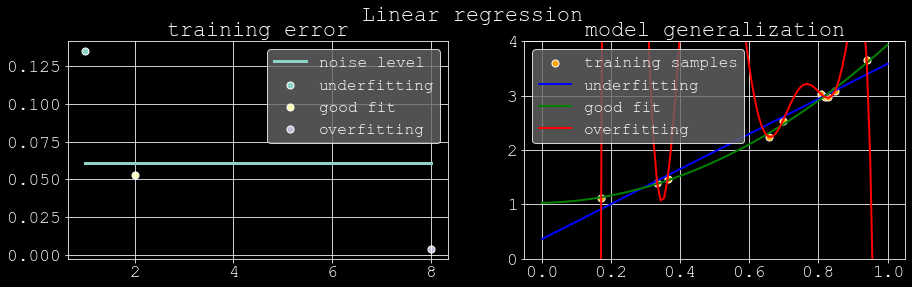

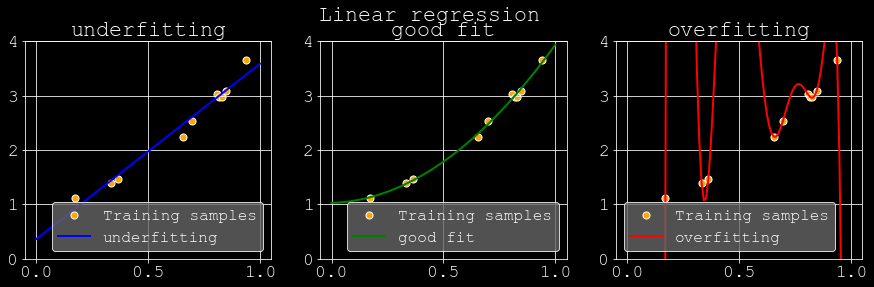

In [13]:
X_plot = x_plot[:, np.newaxis]
ax1, ax2 = prep_plots(["training error", "model generalization"], fig_size=(15,4), fig_num=1)
ax1.plot([1,8], [nnstd, nnstd], label="noise level")
ax2.scatter(x, y, color='orange', edgecolor='w', s=50, marker='o', label="training samples")
colors = ['blue', 'green', 'red']; labels = ['underfitting', 'good fit', 'overfitting']
axes_sub = prep_plots(labels, fig_size=(15,4), fig_num=2)
# Optimize different degree polynomials
for count, degree in enumerate([1,2,8]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    Y_model_err = np.sqrt(np.mean(np.square(y-model.predict(X))))
    y_plot = model.predict(X_plot)
    ax1.scatter(degree, Y_model_err, s=50, marker="o", edgecolor='w', label=labels[count])
    ax2.plot(x_plot, y_plot, color=colors[count], linewidth=2,label=labels[count])
    ax2.set_ylim((0,4))
    axes_sub[count].scatter(x, y, color='orange', edgecolor='w', s=50, marker='o', label="Training samples")
    axes_sub[count].plot(x_plot, y_plot, color=colors[count], linewidth=2,label=labels[count])
    axes_sub[count].set_ylim((0,4))
finalize_plots(axes_sub, fig_title="Linear regression")
finalize_plots([ax1,ax2], fig_title="Linear regression")


Depending on the _capacity_ of the model, what we can observe is that

- `capacity too low   -> underfitting   : prediction variance >  noise variance`
- `adequate capacity  -> good fit       : prediction variance == noise variance`
- `capacity too high  -> overfitting    : prediction variance <  noise variance`


A similar example can be given for a classification problem in two dimensions as follows

<img src="images/01_underfit.png" align="center"/>


<a id="audio"></a>
## Audio applications

In order to test our algorithms on audio and music data, we will work with several datasets that should be downloaded on your local computer first from this [link ![](images/file.png)](https://nuage.ircam.fr/index.php/s/FTsaaAMFV1jEwsk)

  |**Type**|*Origin*|
  |-------:|:---------|
  |**Classification**|[*MuscleFish*](http://knight.cis.temple.edu/~vasilis/Courses/CIS750/Papers/muscle_fish.pdf) dataset|
  |**Music-speech**|[*MIREX Recognition*](http://www.music-ir.org/mirex/wiki/2015:Music/Speech_Classification_and_Detection) set|
  |**Source separation**|[*SMC Mirum*](http://smc.inesctec.pt/research/data-2/) dataset|
  |**Speech recognition**|[*CMU Arctic*](http://festvox.org/cmu_arctic/) dataset|

**Unzip the file and place the `data` folder along with the other code folders**
For the first parts of the tutorial, we will mostly rely solely on the classification dataset. In order to facilitate the interactions, we provide the function `import_dataset` that will allow to import all audio datasets along the tutorials.

```Python
def importDataset(class_path, type):
    """
    Helper function to import datasets
    % class_path  : Path to the dataset (string)
    % type       : Type of dataset (string: 'classify', 'plain', 'metadata')
    """ 
    # Returns the data_struct structure with
    data_struct["filenames"]  # Cell containing the list of audio files
    data_struct["classes"]    # Vector of indexes assigning each file to a class
    data_struct["class_names"] % Cell of class names
    return data_struct
```
  
***

**_Exercise_**  

  1. Launch the import procedure  and check the corresponding structure
  2. Code a count function that prints the name and number of examples for each classes 

***

In [40]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from helper_data import import_dataset
# 0.1 - Import the classification dataset
class_path = 'data/classification';
data_struct = import_dataset(class_path, 'classification');

    - Importing dataset data/classification.



In [41]:
#%% Q-0.1.2 - Count function to print the number of examples

######################
number=np.zeros(len(data_struct['class_names']),int)
for i in data_struct['classes']:
    number [i] +=1
print(data_struct['class_names'])
print(data_struct['classes'])
print(number)
######################
#for i in range(len(number)):
#    print('La classe'.format(data_struct['class_names'][i]) + 'contient' .format(number[i])+ 'éléments')

['bells', 'speech.male', 'water', 'oboe', 'altotrombone', 'speech.female', 'telephone', 'percussion', 'violinpizz', 'laughter', 'machines', 'tubularbells', 'animals', 'violinbowed', 'cellobowed', 'crowds']
[ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 

### Preprocessing

We will rely on a set of spectral transforms that allow to obtain a more descriptive view over the audio information. As most of these are out of the scope of the machine learning course, we redirect you to a [signal processing course](https://ccrma.stanford.edu/~jos/sasp/) proposed by [Julius O. Smith](https://ccrma.stanford.edu/~jos/).  

The following functions to compute various types of transforms are given as part of the basic package, in the `helper_data.py` file  

  |**File**|*Transform*|
  |-------:|:----------|
  |`stft.m`       |[Short-term Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)|
  |`fft2barkmx.m` |[Bark scale](https://en.wikipedia.org/wiki/Bark_scale) transform|
  |`fft2melmx.m`  |[Mel scale](https://en.wikipedia.org/wiki/Mel_scale) transform|
  |`fft2chromamx` |[Chromas vector](https://en.wikipedia.org/wiki/Harmonic_pitch_class_profiles)|
  |`spec2cep.m`   |[Cepstrum](https://en.wikipedia.org/wiki/Cepstrum) transform|
  |`cqt.m`        |[Constant-Q](https://en.wikipedia.org/wiki/Constant_Q_transform) transform|

In order to perform the various computations, we provide the following function, which performs the different transforms on a complete dataset.  

``` Python
def computeTransforms(data_struct)
    """ data_struct   : Dataset structure with filenames """
    return data_struct

# Returns the data_struct structure with
data_struct["spectrum_power"]     # Power spectrum (STFT)
data_struct["spectrum_mel"]       # Spectrum in Mel scale
data_struct["spectrum_chroma"]    # Chroma vectors
data_struct["spectrum_CQT"]       # Constant-Q transform
```


***

**Exercise**  

  1. Launch the transform computation procedure and check the corresponding structure
  2. For each class, select a random element and plot its various transforms on a single plot. You should obtain plots similar to those shown afterwards.
  3. For each transform, try to spot major pros and cons of their representation.
  
***

In [42]:
# 0.2 - Pre-process the audio to obtain spectral transforms 
# (may take around a minute)
from helper_data import compute_transforms
data_struct = compute_transforms(data_struct);

    - Performing transforms.


In [43]:
print(data_struct['spectrum_chroma'][5][2])

[0.1115078  0.10919432 0.12442418 0.34979802 0.42876044 0.43146017
 0.29276714 0.31127435 0.44263005 0.51088244 0.64386183 0.8855401
 1.         1.         1.         1.         1.         1.
 0.9564872  1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [44]:
# Q-0.2.2 - Plot the various transforms 

# Just a little helper to make your figures pretty
from helper_plot import hdr_plot_style
hdr_plot_style()

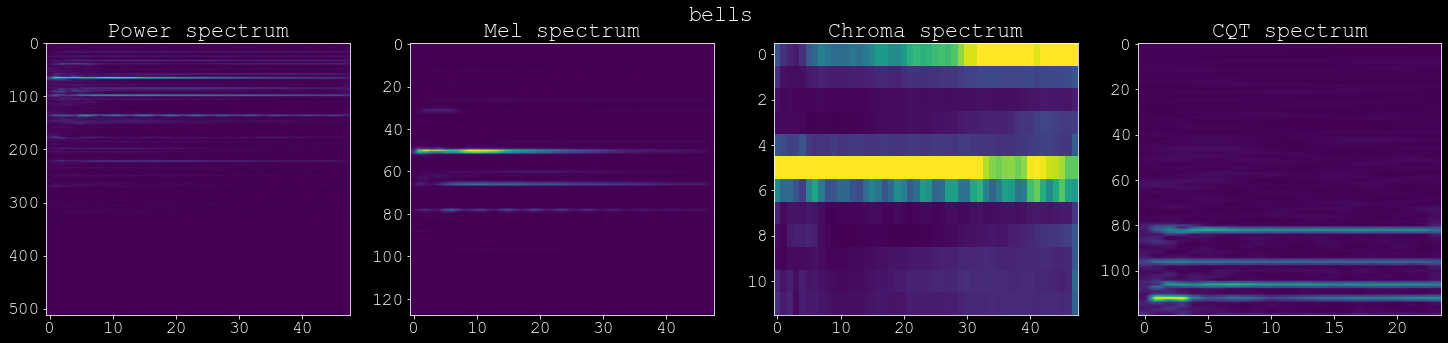

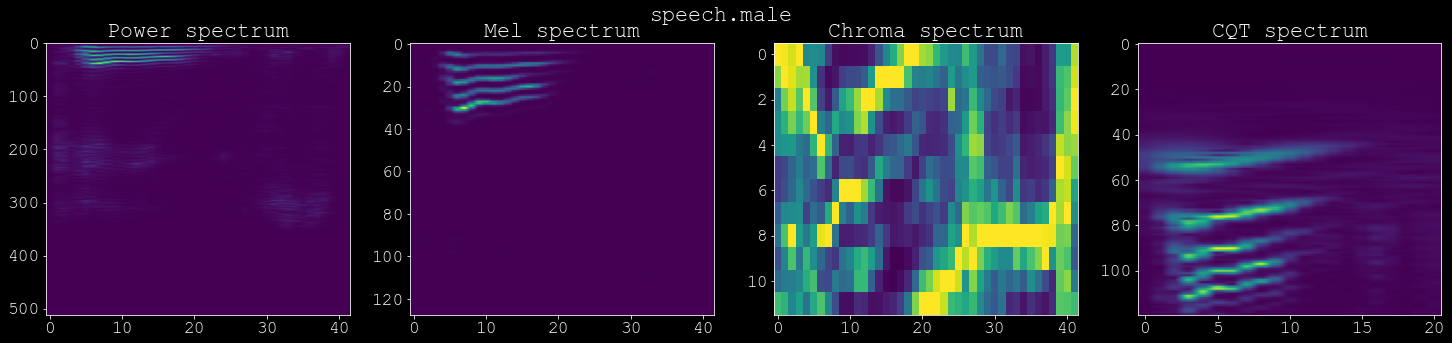

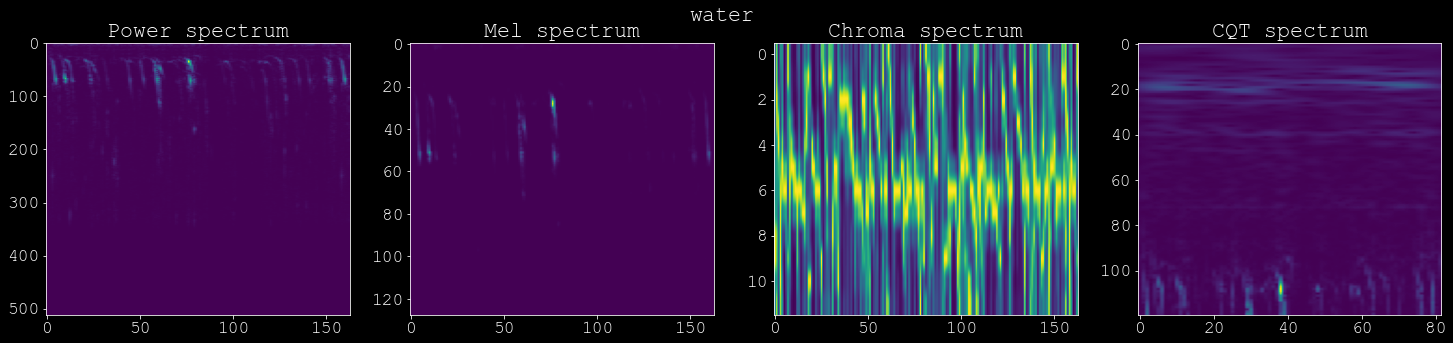

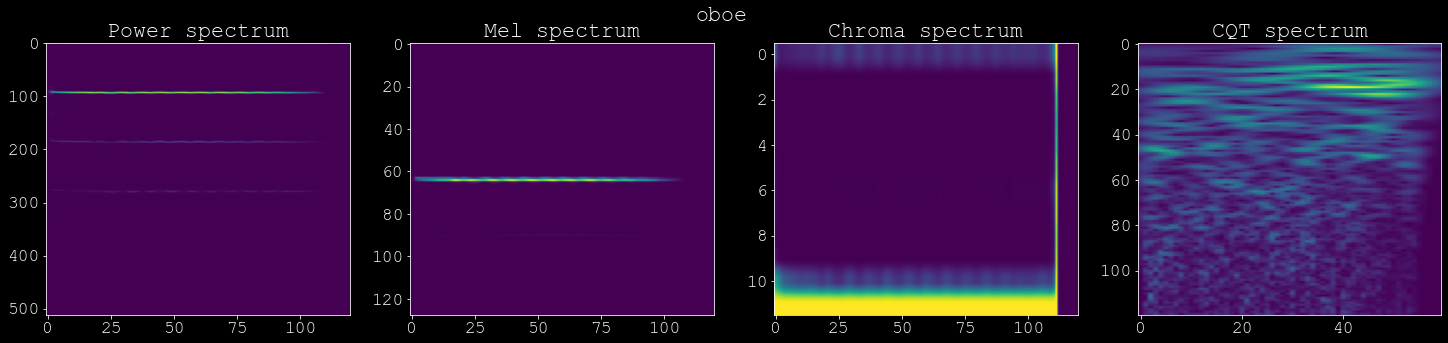

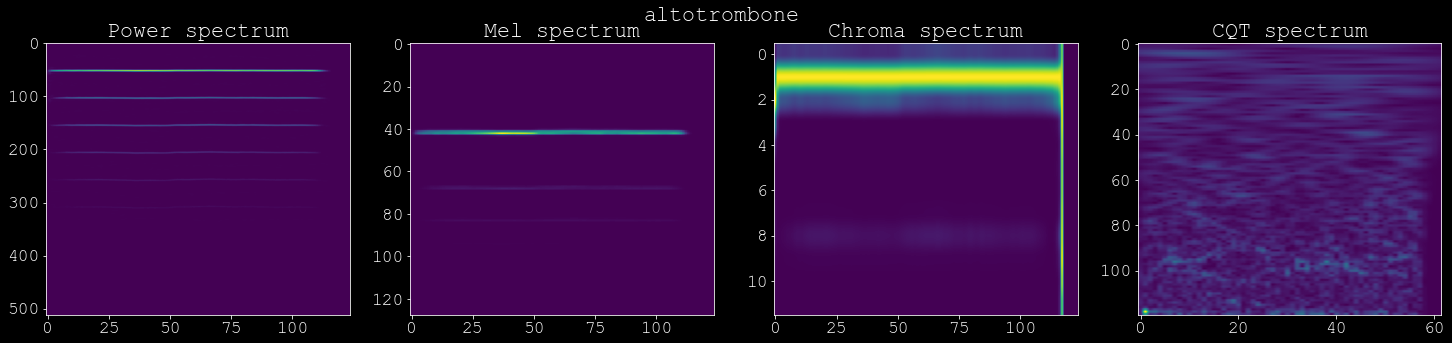

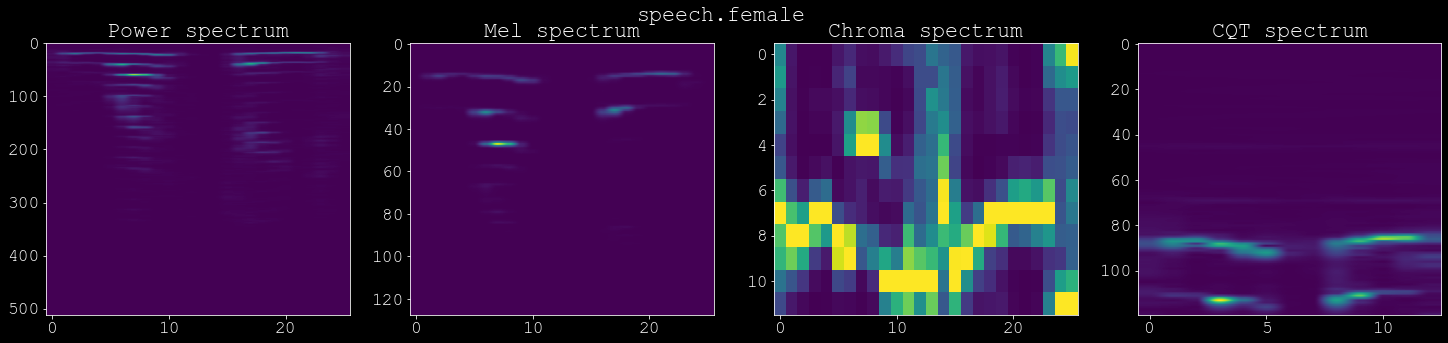

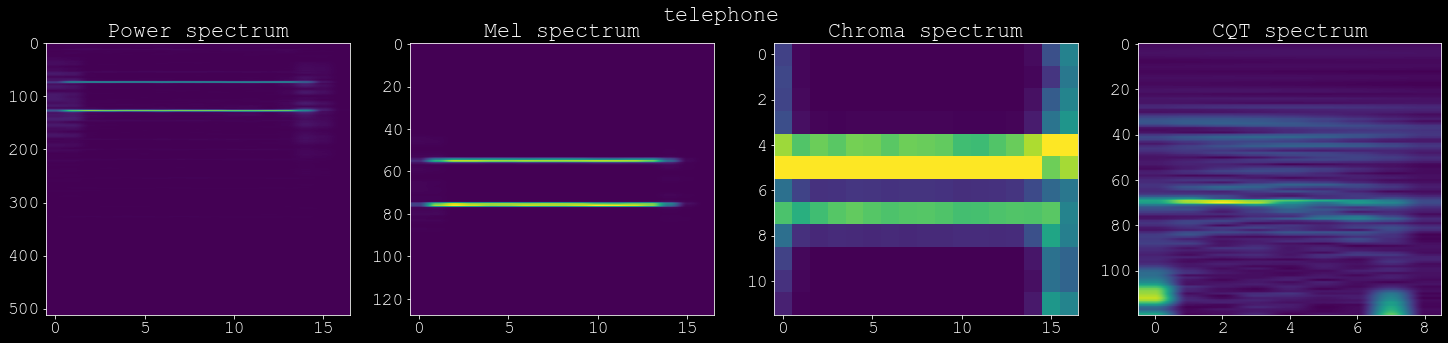

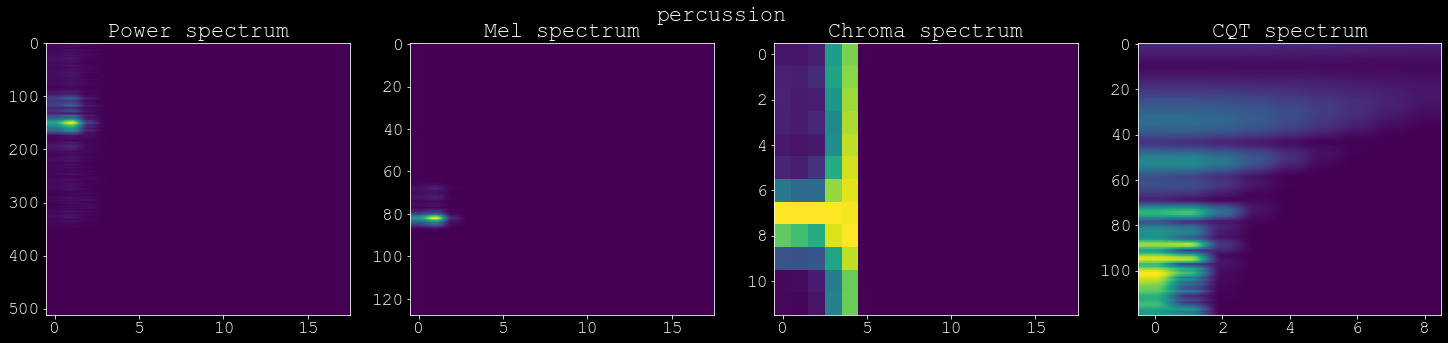

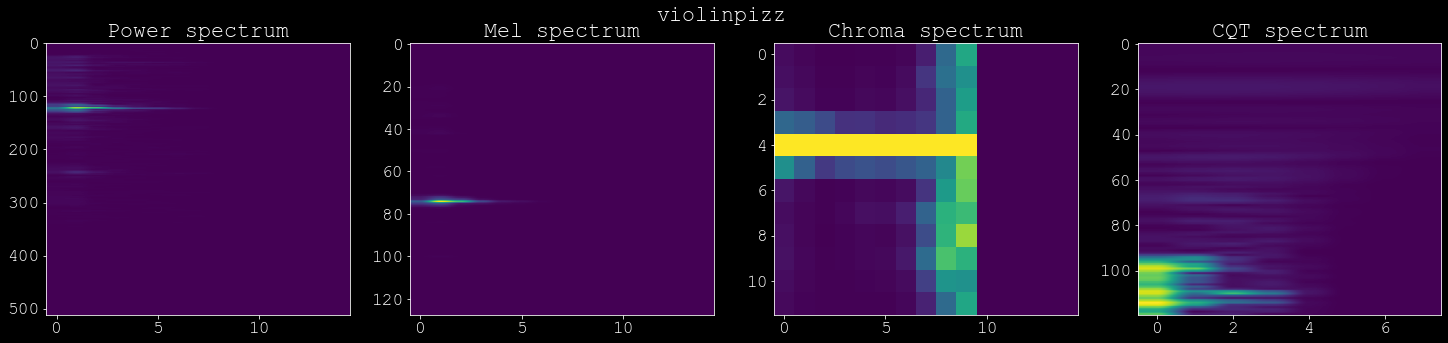

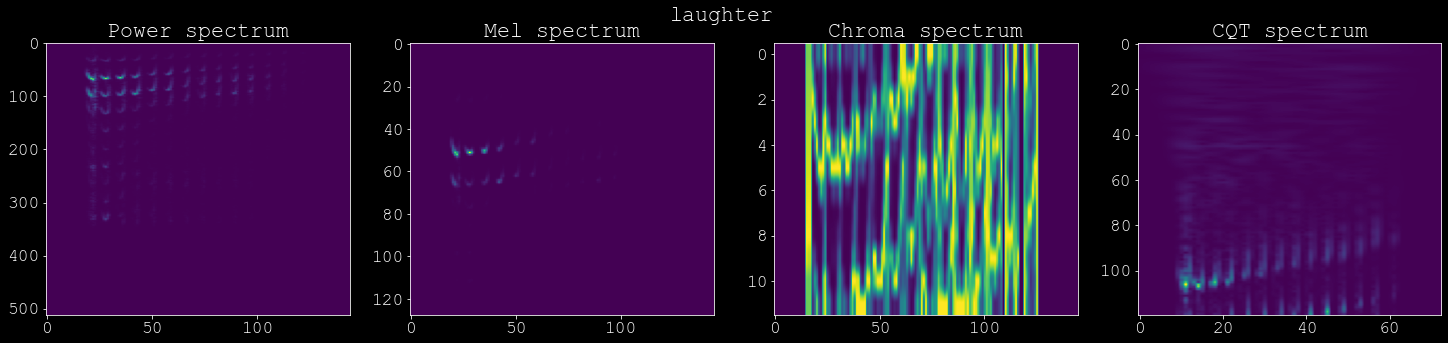

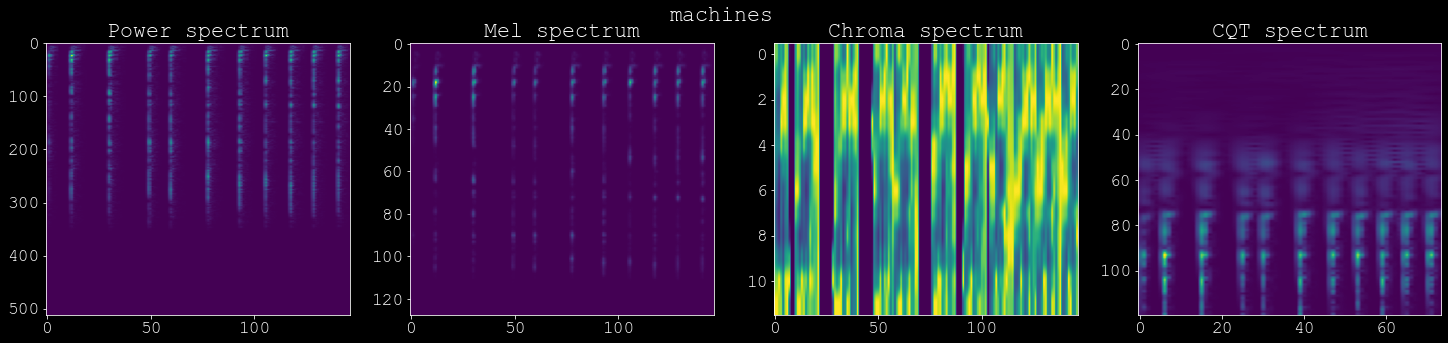

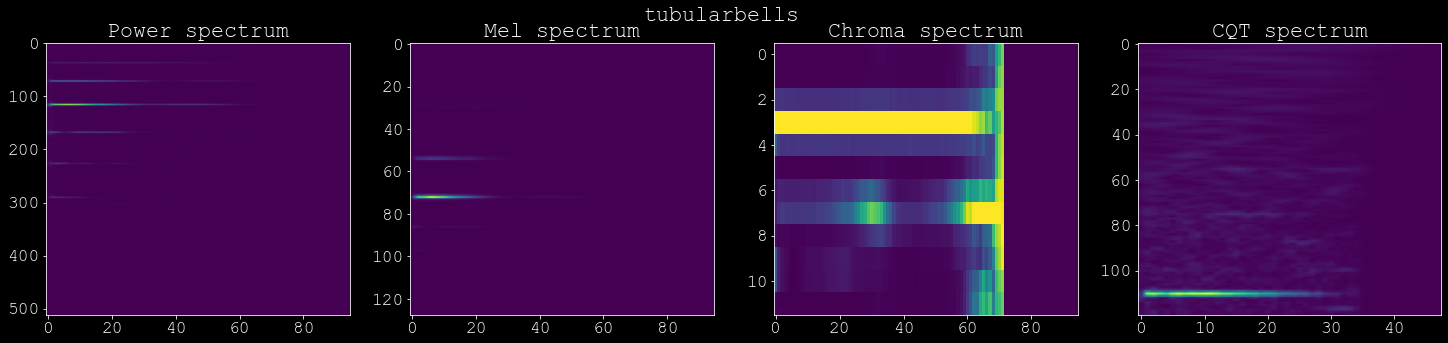

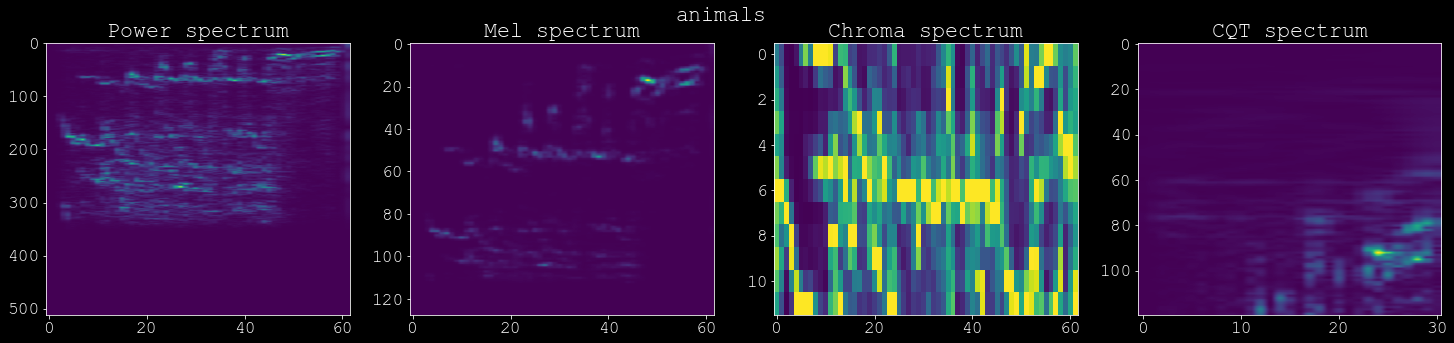

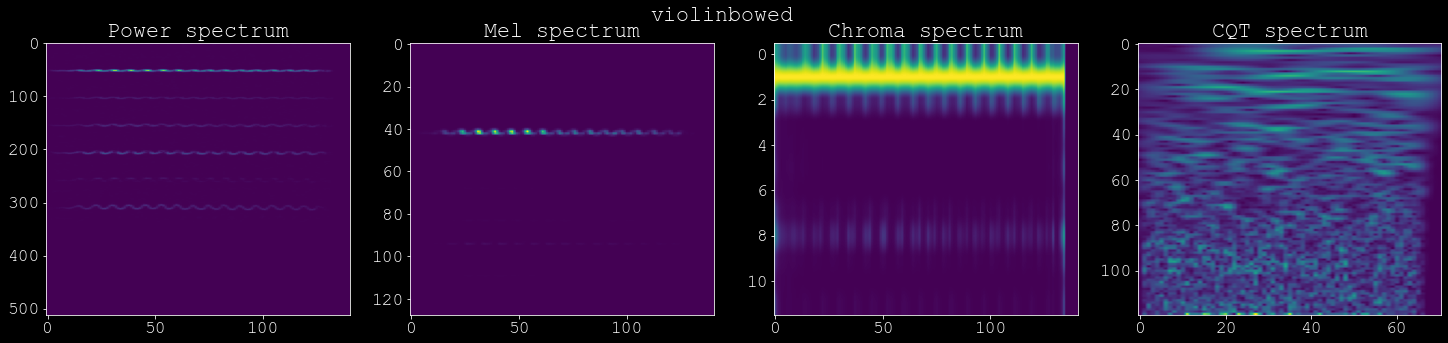

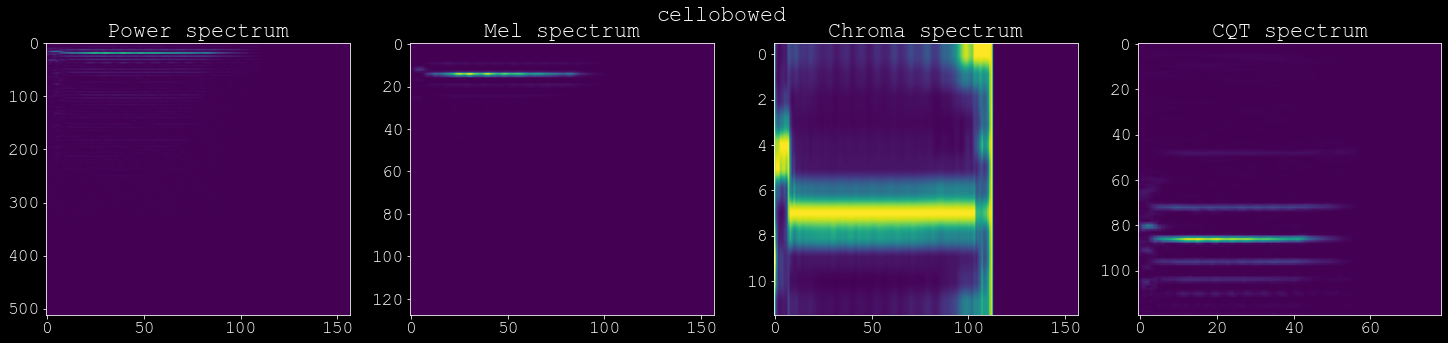

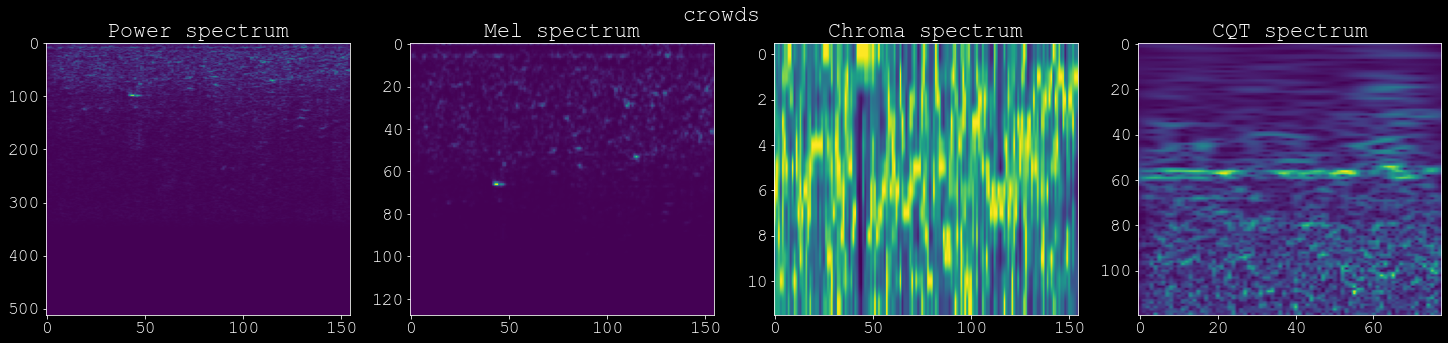

In [45]:
######################
Nbel = 0
for i in range(len(number)): 
    n = np.random.random_integers(Nbel,Nbel+number[i]-1)
    Nbel = Nbel + number[i]

    fig, (ax) = plt.subplots(1,4,figsize=(25,5))
    ax[0].imshow(data_struct['spectrum_power'][n], aspect='auto')
    ax[0].set_title('Power spectrum')
    
    ax[1].imshow(data_struct['spectrum_mel'][n], aspect='auto')
    ax[1].set_title('Mel spectrum')
    
    ax[2].imshow(data_struct['spectrum_chroma'][n], aspect='auto')
    ax[2].set_title('Chroma spectrum')
    
    ax[3].imshow(data_struct['spectrum_CQT'][n], aspect='auto')
    ax[3].set_title('CQT spectrum')

    fig.suptitle(data_struct['class_names'][i])

######################

### Features

<div markdown = "1">

As you might have noted from the previous exercice, most spectral transforms have a very high dimensionality, and might not be suited to exhibit the relevant structure of different classes. To that end, we provide a set of functions for computing several spectral features in the `helper_data` folder, we redirect interested readers to this [exhaustive article](http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf) on spectral features computation.

  |**File**|*Transform*|
  |-------:|:----------|
  |`spectral_centroid`|Spectral centroid|
  |`spectral_bandwidth`|Spectral bandwidth|
  |`spectral_contrast`|Spectral contrast|
  |`spectral_flatness`|Spectral flatness|
  |`spectral_rolloff`|Spectral rolloff|

Once again, we provide a function to perform the computation of different features on a complete set. Note that for each feature, we compute the temporal evolution in a vector along with the mean and standard deviation of each feature. We only detail the resulting data structure for a single feature (`SpectralCentroid`).  

``` Python
def data_struct = computeFeatures(data_struct)
     """ data_struct   : Dataset structure with filenames """
    return data_struct

% Returns the data_struct structure with
data_struct["spectral_centroid"]      # Temporal value of a feature
data_struct["spectral_centroid_mean"] # Mean value of that feature
data_struct["spectral_centroid_std"]  # Standard deviation
```

***

**Exercise**

  1. Launch the feature computation procedure and check the corresponding structure
  2. This time for each class, superimpose the plots of various features on a single plot, along with a boxplot of mean and standard deviations. You should obtain plots similar to those shown afterwards.
  3. What conclusions can you make on the discriminative power of each feature ?
  4. Perform scatter plots of the mean features for all the dataset, while coloring different classes.
  5. What conclusions can you make on the discriminative power of mean features ?

***

In [ ]:
#%%
# 0.3 - Compute a set of temporal and spectral features
# (may take around 1-2 minutes)
from helper_data import compute_features
data_struct = compute_features(data_struct);

In [ ]:
#%% Q-0.3.2 - Plot the various features 

# Just a little helper to make your figures pretty
from helper_plot import hdr_plot_style
hdr_plot_style()
# Use these styles for boxplot
boxprops=dict(linewidth=3, color='white')
whiskerprops=dict(linewidth=3, color='white')
medianprops=dict(linewidth=2.5, color='firebrick')
flierprops = dict(markeredgecolor='white', markerfacecolor='firebrick')

######################
# YOUR CODE GOES HERE
######################


In [ ]:
#%% Q-0.3.4 - Observe the distribution of classes for different features

# This allows to use 3D rendering in matplotlib
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(12,8))
# Create a vector of random colors for each class
colorVect = np.zeros((3, len(data_struct["class_names"])));
for c in range(len(data_struct["class_names"])):
    colorVect[:,c] = np.random.rand(3);

######################
# YOUR CODE GOES HERE
######################


That's it for this tutorial, now remember that we can use any form of description (features) as a basis for learning algorithms. We will see in the next tutorial what we an do with these features.